In [269]:
import time
import timeit

import pandas as pd
import numba as nb
import numpy as np

In [2]:
!mkdir dataset

In [3]:
!curl https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip --output dataset/data_original.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  9 75.1M    9 7312k    0     0  4766k      0  0:00:16  0:00:01  0:00:15 4769k
 20 75.1M   20 15.6M    0     0  6264k      0  0:00:12  0:00:02  0:00:10 6265k
 30 75.1M   30 23.1M    0     0  6724k      0  0:00:11  0:00:03  0:00:08 6726k
 44 75.1M   44 33.7M    0     0  7642k      0  0:00:10  0:00:04  0:00:06 7644k
 55 75.1M   55 41.8M    0     0  7780k      0  0:00:09  0:00:05  0:00:04 8672k
 69 75.1M   69 52.4M    0     0  8226k      0  0:00:09  0:00:06  0:00:03 9289k
 81 75.1M   81 61.5M    0     0  8387k      0  0:00:09  0:00:07  0:00:02 9479k
 92 75.1M   92 69.5M    0     0  8329k      0  0:00:09  0:00:08  0:00:01 9453k
100 75.1M  100 75.1M    0     0  8536k      0  0:00

In [4]:
import zipfile

with zipfile.ZipFile("dataset/data_original.zip", mode="r") as archive:
    archive.extractall("dataset")

In [5]:
!del "dataset\data_original.zip"

In [6]:
interactions = pd.read_csv('dataset/kion_train/interactions.csv')
users = pd.read_csv('dataset/kion_train/users.csv')
items = pd.read_csv('dataset/kion_train/items.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [7]:
def generate_subsample(users_count: int, top_k: int, data: pd.DataFrame=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

In [259]:
def map_at_k_naive(target: np.ndarray, users: np.ndarray, recs: np.ndarray,  k: int):        
    maps = []
    for i, user in enumerate(users):
        score = 0.0
        correct = 0.0
        if len(recs[i]) > k:
            recs[i] = recs[:k]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target and rec not in recs[i][:j]:
                correct += 1.0
                score += correct / (j + 1.0)
        maps.append(score / min(len(user_target), k))
        
    return sum(maps) / len(users)

In [260]:
@nb.njit(cache=True, parallel=True)
def map_at_k_numba(target: np.ndarray, users: np.ndarray, recs: np.ndarray, k: int):
    maps = np.zeros(len(users))
    for i in nb.prange(len(users)):
        score = 0.0
        correct = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        if len(recs[i]) > k:
            recs[i] = recs[:k]
        for j, rec in enumerate(recs[i]):
            if rec in user_target and rec not in recs[i][:j]:
                correct += 1.0
                score += correct / (j + 1.0)
        maps[i] = (score / min(len(user_target), k))
        
    return maps.mean()

In [261]:
def map_at_k_pandas(df_target: pd.DataFrame, users: np.ndarray, recs: np.ndarray, k: int = 10):
    df_recs = pd.DataFrame({
        'user_id': np.repeat(users, recs.shape[1]),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_recs = df_target.merge(df_recs, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df_recs = df_recs.sort_values(by=['user_id', 'rank'])
    df_recs['TP@k'] = df_recs['rank'] < (k + 1)
    df_recs['Prec@k/actual'] = (df_recs.groupby('user_id')['TP@k'].cumsum() / df_recs['rank']) /\
                                df_recs.groupby('user_id')['item_id'].transform('count')
    
    return df_recs.groupby('user_id')['Prec@k/actual'].sum().mean()

In [266]:
users_counts = [100, 1000, 10000, 100000]
top_ks = [10, 50, 100]
n_runs = 10

In [267]:
avg_time_naive = np.zeros((len(users_counts), len(top_ks)))
avg_time_numba = np.zeros((len(users_counts), len(top_ks)))
avg_time_pandas = np.zeros((len(users_counts), len(top_ks)))

In [270]:
for i, user_count in enumerate(users_counts):
    for j, top_k in enumerate(top_ks):
        df, users, recs = generate_subsample(user_count, top_k)
        target = df.values
        
        print(f'Run naive user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('map_at_k_naive(target, users, recs, top_k)', "from __main__ import map_at_k_naive, target, users, recs, top_k" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('map_at_k_numba(target, users, recs, top_k)', "from __main__ import map_at_k_numba, target, users, recs, top_k", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('map_at_k_pandas(df, users, recs, top_k)', "from __main__ import map_at_k_pandas, df, users, recs, top_k", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_pandas[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 10 times
Avg time: 0.0034 seconds
Run numba user_count: 100, top_k: 10 for 10 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 10 for 10 times
Avg time: 0.0064 seconds
Run naive user_count: 100, top_k: 50 for 10 times
Avg time: 0.0141 seconds
Run numba user_count: 100, top_k: 50 for 10 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 50 for 10 times
Avg time: 0.0067 seconds
Run naive user_count: 100, top_k: 100 for 10 times
Avg time: 0.0272 seconds
Run numba user_count: 100, top_k: 100 for 10 times
Avg time: 0.0001 seconds
Run pandas user_count: 100, top_k: 100 for 10 times
Avg time: 0.0072 seconds
Run naive user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0412 seconds
Run numba user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0015 seconds
Run pandas user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0098 seconds
Run naive user_count: 1000, top_k: 50 for 10 times
Avg time: 0.1461 seconds
Run numba user

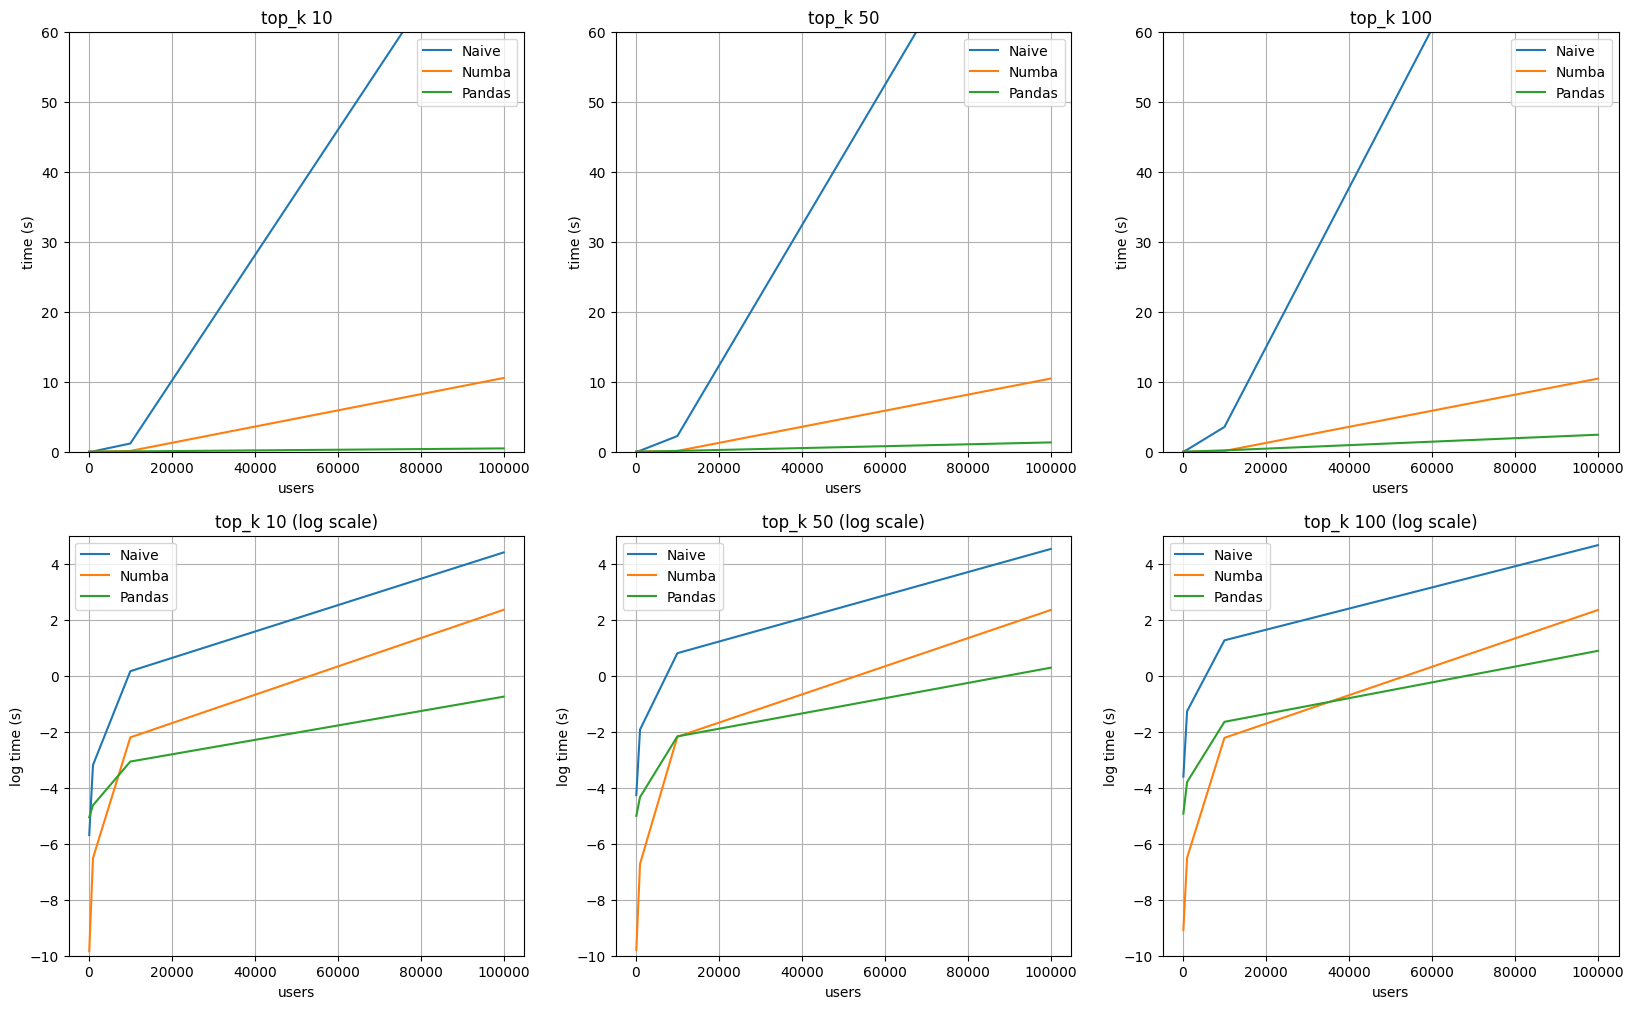

In [273]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(3):
    ax[0][i].plot(users_counts, avg_time_naive[:, i], label='Naive')
    ax[0][i].plot(users_counts, avg_time_numba[:, i], label='Numba')
    ax[0][i].plot(users_counts, avg_time_pandas[:, i], label='Pandas')
    ax[0][i].set_title(f'top_k {top_ks[i]}')
    ax[0][i].set_xlabel('users')
    ax[0][i].set_ylabel('time (s)')
    ax[0][i].set_ylim(0, 60)
    ax[0][i].grid()
    ax[0][i].legend()
    
    # log scale
    ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive')
    ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba')
    ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas')
    ax[1][i].set_title(f'top_k {top_ks[i]} (log scale)')
    ax[1][i].set_xlabel('users')
    ax[1][i].set_ylabel('log time (s)')
    ax[1][i].set_ylim(-10, 5)
    ax[1][i].grid()
    ax[1][i].legend()
plt.show()

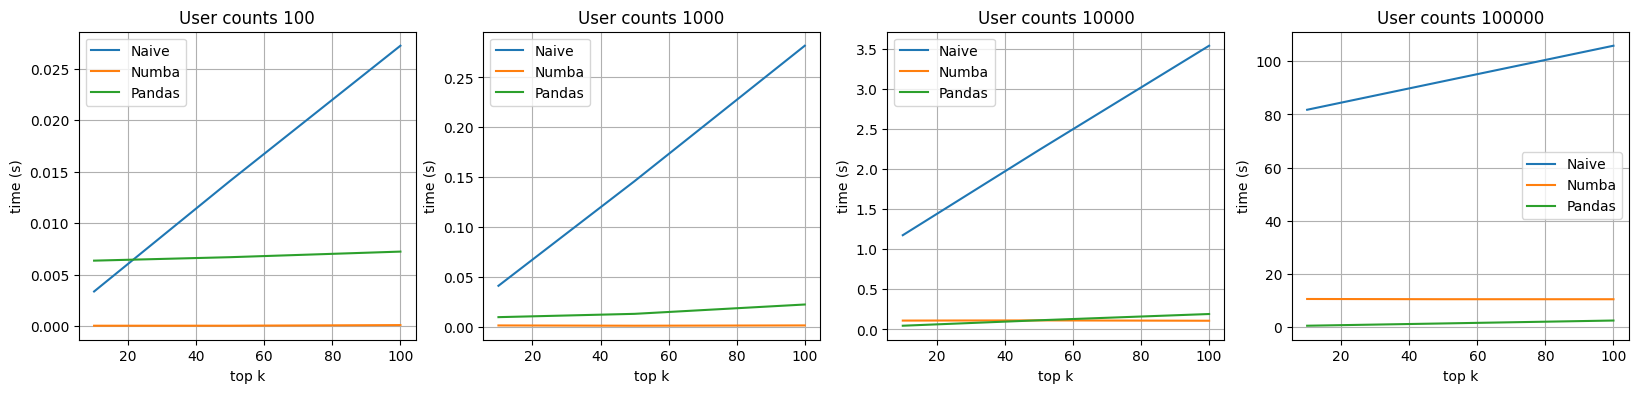

In [274]:
_, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    ax[i].plot(top_ks, avg_time_naive[i, :], label='Naive')
    ax[i].plot(top_ks, avg_time_numba[i, :], label='Numba')
    ax[i].plot(top_ks, avg_time_pandas[i, :], label='Pandas')
    ax[i].set_title(f'User counts {users_counts[i]}')
    ax[i].grid()
    ax[i].set_xlabel('top k')
    ax[i].set_ylabel('time (s)')
    ax[i].legend()
plt.show()